# Clasificador de Imágenes de Gatos (Siamese vs Sphynx) usando OpenCV y ML

## Introducción

El objetivo de esta práctica es desarrollar un clasificador de imágenes que pueda distinguir entre dos razas específicas de gatos (Siamese y Sphynx) utilizando el conjunto de datos Oxford-IIIT Pet Dataset. Se utilizará OpenCV para preprocesar las imágenes y extraer características relevantes, y luego se entrenará un modelo de aprendizaje automático con dichas características. El objetivo principal no es lograr el modelo más preciso, sino comprender y mejorar el proceso de extracción y refinamiento de información a partir de los datos de las imágenes.

## Pasos a seguir durante el trabajo

### 1. Importación de Librerías

Se importan todas las librerías necesarias para el procesamiento de imágenes y el entrenamiento del modelo, incluyendo OpenCV, numpy, pandas, matplotlib, scikit-learn, etc

### 2. Carga y visualización de imágenes

Se cargan las imágenes y se realiza una visualización inicial.

### 3. Definición y creación de las funciones de preprocesamiento usadas

Se definen y crean diversas funciones de preprocesamiento para las imágenes, como ajuste de brillo y contraste, aplicación de máscaras, transformación de Fourier, y otras técnicas que mejoren la calidad y relevancia de las características extraídas.

### 4. Definición y creación de una clase Pipeline que junte los tres procesos: Extracción, transformación y entrenamiento (y validación) del modelo

Se crea una clase Pipeline que integra los procesos de extracción de características, transformación de las imágenes y entrenamiento del modelo. Esta clase facilita la experimentación y evaluación de diferentes estrategias de preprocesamiento y modelado.

### 5. Ejecución del Proceso Completo: Definición de intentos según ciertos objetivos de preprocesamiento de las imágenes

Se ejecuta el pipeline con diferentes configuraciones y estrategias de preprocesamiento. Cada intento se documenta, incluyendo la configuración de las funciones aplicadas y los resultados obtenidos en términos de precisión, recall, f1-score, ... del modelo.

### 6. Predicción final

Se desarrolla una función para mostrar algunas imágenes con sus etiquetas y predicciones para verificar visualmente el rendimiento del modelo. Esto permite una evaluación cualitativa del modelo y su capacidad para distinguir entre las dos razas de gatos.

### Problemas Encontrados y Soluciones propuestas

1. **Problema con la cantidad de canales en las imágenes**:
   - **Solución**: Asegurar que todas las imágenes tengan tres canales (BGR) antes de aplicar cualquier transformación.

2. **Problema con la precisión del modelo**:
   - **Solución**: Ajustar las funciones de preprocesamiento y probar diferentes combinaciones y órdenes de aplicación para mejorar la extracción de características relevantes.



In [2]:
!pip install opencv-python umap-learn scikit-learn

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.image as mpimg
import random
from sklearn.manifold import TSNE
import umap
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix


c:\Users\Jorge\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [78]:
# En caso de usar colab
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

# Carga de datos, creación de datasets de test y train [2 carpetas según raza de gato]

In [3]:
images_path = "images"
annotations_path = "annotations"

trainval = open(os.path.join(annotations_path, "trainval.txt")).readlines()
test = open(os.path.join(annotations_path, "test.txt")).readlines()

# Crear directorios para las razas de gato Siamese y Sphynx
os.makedirs(os.path.join(images_path, "train", "Siamese"), exist_ok=True)
os.makedirs(os.path.join(images_path, "train", "Sphynx"), exist_ok=True)
os.makedirs(os.path.join(images_path, "test", "Siamese"), exist_ok=True)
os.makedirs(os.path.join(images_path, "test", "Sphynx"), exist_ok=True)

def classify_image(line, subset):
    elements = line.split(" ")
    breed_info = elements[0].split("_")
    breed = breed_info[0]

    if breed in ["Siamese", "Sphynx"]:
        oldpath = os.path.join(images_path, f"{elements[0]}.jpg")
        newpath = os.path.join(images_path, subset, breed, f"{elements[0]}.jpg")
        if os.path.isfile(oldpath):
            os.rename(oldpath, newpath)

for line in trainval:
    classify_image(line, "train")

for line in test:
    classify_image(line, "test")


# Visualización de imágenes previa

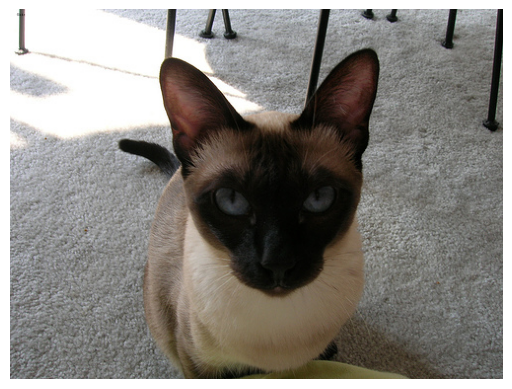

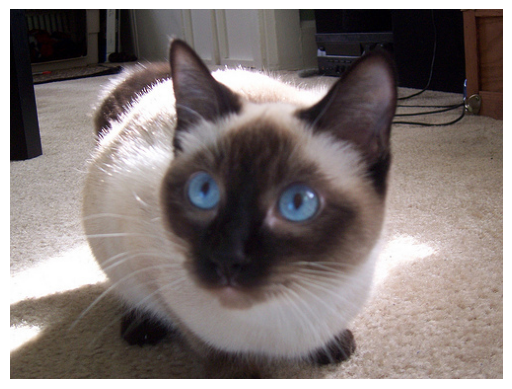

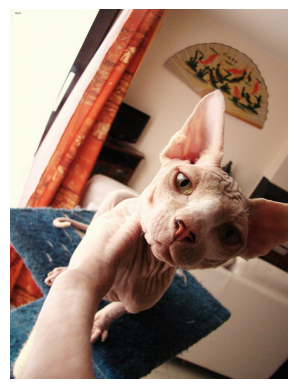

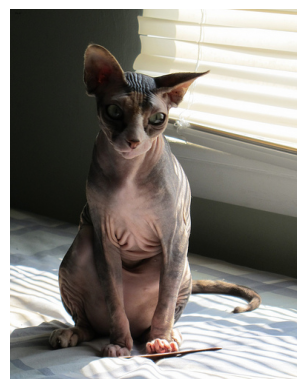

In [4]:
# Función para cargar imágenes de un directorio dado
def load_images_from_directory(directory, num_images=2):
    image_files = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    selected_files = random.sample(image_files, min(len(image_files), num_images))
    images = [mpimg.imread(f) for f in selected_files]
    return images

# Cargar algunas imágenes de los directorios de train y test
train_siamese_images = load_images_from_directory(os.path.join(images_path, "train", "Siamese"))
test_sphynx_images = load_images_from_directory(os.path.join(images_path, "test", "Sphynx"))

# Visualizar las imágenes
def show_images(images):
    for img in images:
        plt.imshow(img / 255.0)
        plt.axis('off')
        plt.show()

# Mostrar algunas imágenes de train y test
show_images(train_siamese_images)
show_images(test_sphynx_images)

# Funciones de preprocesamiento necesarias

In [5]:
def apply_fourier_transform(img):
    """
    Aplica la transformada de Fourier a la imagen.

    Args:
        img (np.array): Imagen de entrada.

    Returns:
        np.array: Imagen con la transformada de Fourier aplicada.
    """
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    f = np.fft.fft2(img_gray)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift))
    magnitude_spectrum = np.uint8(magnitude_spectrum)  # Convertir a uint8
    return cv2.merge([magnitude_spectrum] * 3)  # Convertir a 3 canales para mantener el formato

def apply_mask(img):
    """
    Aplica una máscara para eliminar el fondo y resaltar solo al gato.

    Args:
        img (np.array): Imagen de entrada.

    Returns:
        np.array: Imagen con el fondo eliminado.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)
    masked_img = cv2.bitwise_and(img, img, mask=mask)
    return masked_img



def convert_to_hsv(img):
    """
    Convierte la imagen al espacio de color HSV y extrae el canal de saturación.

    Args:
        img (np.array): Imagen de entrada.

    Returns:
        np.array: Imagen con el canal de saturación resaltado.
    """
    if len(img.shape) == 2:
        # Si la imagen es en escala de grises, convertirla a BGR
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    elif img.shape[2] == 1:
        # Si la imagen tiene un solo canal, convertirla a BGR
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    return s



def adjust_brightness_contrast(image, alpha=1.0, beta=0):
    """
    Ajusta el brillo y el contraste de la imagen.

    Args:
        image (np.array): Imagen de entrada.
        alpha (float): Factor de contraste.
        beta (int): Valor de brillo.

    Returns:
        np.array: Imagen con brillo y contraste ajustados.
    """
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

def augment_image(image, img_size):
    """
    Redimensiona la imagen

    Args:
        image (np.array): Imagen a aumentar.
        img_size (tuple): Tamaño al que se redimensionarán las imágenes.

    Returns:
        list: Lista de imágenes aumentadas.
    """
    augmented_images = []
    angles = [-30, -15, 15, 30]
    translations = [(-10, -10), (-10, 10), (10, -10), (10, 10)]
    scales = [0.8, 1.2]

    for angle in angles:
        aug_img = rotate_image(image, angle)
        aug_img = cv2.resize(aug_img, img_size)
        augmented_images.append(aug_img)

    for (x, y) in translations:
        aug_img = transfer_image(image, x, y)
        aug_img = cv2.resize(aug_img, img_size)
        augmented_images.append(aug_img)

    for scale in scales:
        aug_img = scale_image(image, scale)
        aug_img = cv2.resize(aug_img, img_size)
        augmented_images.append(aug_img)

    aug_img = adjust_brightness_contrast(image, alpha=1.5, beta=50)
    aug_img = cv2.resize(aug_img, img_size)
    augmented_images.append(aug_img)

    aug_img = adjust_brightness_contrast(image, alpha=0.5, beta=-50)
    aug_img = cv2.resize(aug_img, img_size)
    augmented_images.append(aug_img)

    return augmented_images

def rotate_image(image, angle):
    """
    Rota la imagen un ángulo especificado.

    Args:
        image (np.array): Imagen a rotar.
        angle (float): Ángulo de rotación en grados.

    Returns:
        np.array: Imagen rotada.
    """
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    return cv2.warpAffine(image, M, (w, h))

def transfer_image(image, x, y):
    """
    Traslacion (afín) de la imagen en las direcciones x e y especificadas.

    Args:
        image (np.array): Imagen a traducir.
        x (int): Desplazamiento en el eje x.
        y (int): Desplazamiento en el eje y.

    Returns:
        np.array: Imagen traducida.
    """
    M = np.float32([[1, 0, x], [0, 1, y]])
    h, w = image.shape[:2]
    return cv2.warpAffine(image, M, (w, h))

def scale_image(image, scale):
    """
    Aplica factor de escala a la imagen.

    Args:
        image (np.array): Imagen a escalar.
        scale (float): Factor de escala.

    Returns:
        np.array: Imagen escalada.
    """
    h, w = image.shape[:2]
    return cv2.resize(image, (int(w*scale), int(h*scale)))

def extract_sift_features(images):
    """
    Extrae características SIFT de un conjunto de imágenes.

    Args:
        images (np.array): Conjunto de imágenes.

    Returns:
        np.array: Características extraídas.
    """
    sift = cv2.SIFT_create()
    features = []
    max_features = 0

    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kp, des = sift.detectAndCompute(gray, None)
        if des is not None:
            features.append(des.flatten())
            if des.shape[0] > max_features:
                max_features = des.shape[0]
        else:
            features.append(np.zeros(128))

    # Padding the features to have the same size
    for i in range(len(features)):
        if len(features[i]) < max_features * 128:
            features[i] = np.pad(features[i], (0, max_features * 128 - len(features[i])), mode='constant')

    return np.array(features)

def extract_surf_features(images):
    """
    Extrae características SURF de un conjunto de imágenes.

    Args:
        images (np.array): Conjunto de imágenes.

    Returns:
        np.array: Características extraídas.
    """
    surf = cv2.xfeatures2d.SURF_create()
    features = []
    max_features = 0

    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kp, des = surf.detectAndCompute(gray, None)
        if des is not None:
            features.append(des.flatten())
            if des.shape[0] > max_features:
                max_features = des.shape[0]
        else:
            features.append(np.zeros(64))

    # Padding the features to have the same size
    for i in range(len(features)):
        if len(features[i]) < max_features * 64:
            features[i] = np.pad(features[i], (0, max_features * 64 - len(features[i])), mode='constant')

    return np.array(features)

def extract_orb_features(images):
    """
    Extrae características ORB de un conjunto de imágenes.

    Args:
        images (np.array): Conjunto de imágenes.

    Returns:
        np.array: Características extraídas.
    """
    orb = cv2.ORB_create()
    features = []
    max_features = 0

    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kp, des = orb.detectAndCompute(gray, None)
        if des is not None:
            features.append(des.flatten())
            if des.shape[0] > max_features:
                max_features = des.shape[0]
        else:
            features.append(np.zeros(32))

    # Padding the features to have the same size
    for i in range(len(features)):
        if len(features[i]) < max_features * 32:
            features[i] = np.pad(features[i], (0, max_features * 32 - len(features[i])), mode='constant')

    return np.array(features)

def highlight_gray_tones(img):
    """
    Resalta los tonos grisáceos de la imagen para distinguir los gatos esfinge de los siameses.

    Args:
        img (np.array): Imagen de entrada.

    Returns:
        np.array: Imagen con los tonos grisáceos resaltados.
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_gray = np.array([0, 0, 40])
    upper_gray = np.array([180, 50, 255])
    mask = cv2.inRange(hsv, lower_gray, upper_gray)
    result = cv2.bitwise_and(img, img, mask=mask)
    return result

# clase Pipeline de preprocesamiento

In [6]:
class Pipeline:
    def __init__(self, path_siamese, path_sphynx, img_size=(128, 128)):
        self.path_siamese = path_siamese
        self.path_sphynx = path_sphynx
        self.img_size = img_size
        self.images = []
        self.labels = []
        self.preprocess_functions = []
        self.breeds = ['Siamese', 'Sphynx']
        self.model = None

    def add_preprocess_function(self, func):
        """
        Añade una función de preprocesamiento a la lista de funciones.

        Args:
            func (function): Función de preprocesamiento.
        """
        self.preprocess_functions.append(func)

    def load_images(self):
        """
        Carga y preprocesa las imágenes de las razas especificadas.

        Returns:
            np.array: Imágenes cargadas y preprocesadas.
            np.array: Etiquetas correspondientes a las imágenes.
        """
        for breed, path in [('Siamese', self.path_siamese), ('Sphynx', self.path_sphynx)]:
            for img_name in os.listdir(path):
                if img_name.endswith('.jpg'):
                    img_path = os.path.join(path, img_name)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, self.img_size)
                        if len(img.shape) == 2 or img.shape[2] == 1:
                            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
                        for func in self.preprocess_functions:
                            img = func(img)
                        self.images.append(img)
                        self.labels.append(self.breeds.index(breed))
        self.images = np.array(self.images)
        self.labels = np.array(self.labels)

    def preprocess_image(self, img):
        """
        Aplica las funciones de preprocesamiento a la imagen.

        Args:
            img (np.array): Imagen a preprocesar.

        Returns:
            np.array: Imagen preprocesada.
        """
        for func in self.preprocess_functions:
            img = func(img)
        return img

    def augment_images(self):
        """
        Redimensiona las imagenes.

        Returns:
            np.array: Imágenes aumentadas.
            np.array: Etiquetas correspondientes a las imágenes aumentadas.
        """
        augmented_images = []
        augmented_labels = []
        for img, label in zip(self.images, self.labels):
            augmented_images.append(img)
            augmented_labels.append(label)
            augmented_set = augment_image(img, self.img_size)
            for aug_img in augmented_set:
                augmented_images.append(aug_img)
                augmented_labels.append(label)
        self.images = np.array(augmented_images)
        self.labels = np.array(augmented_labels)

    def extract_features(self, images, method='orb'):
        """
        Extrae características de las imágenes usando el método especificado.

        Args:
            images (np.array): Imágenes de las que extraer características.
            method (str): Método de extracción de características ('sift', 'surf', 'orb').

        Returns:
            np.array: Características extraídas.
        """
        if method == 'sift':
            return extract_sift_features(images)
        elif method == 'surf':
            return extract_surf_features(images)
        elif method == 'orb':
            return extract_orb_features(images)
        else:
            raise ValueError("Método de extracción de características no soportado: {}".format(method))

    def apply_tsne(self, features):
        """
        Aplica T-SNE para reducir la dimensionalidad de las características.

        Args:
            features (np.array): Características extraídas.

        Returns:
            np.array: Embedding de T-SNE.
        """
        tsne = TSNE(n_components=2, random_state=42)
        embedding = tsne.fit_transform(features)
        return embedding

    def plot_embedding(self, embedding, title='Embedding of Cat Breeds'):
        """
        Grafica el embedding en 2D con las etiquetas de las imágenes.

        Args:
            embedding (np.array): Embedding de T-SNE o UMAP.
        """
        plt.figure(figsize=(12, 8))
        for i, label in enumerate(np.unique(self.labels)):
            plt.scatter(
                embedding[self.labels == label, 0],
                embedding[self.labels == label, 1],
                label=label
            )
        plt.legend()
        plt.title(title)
        plt.show()

    def train_and_evaluate_model(self, features):
        """
        Entrena y evalúa un modelo de clasificación usando las características extraídas.

        Args:
            features (np.array): Características extraídas.
        """
        X_train, X_test, y_train, y_test = train_test_split(features, self.labels, test_size=0.3, random_state=42)
        model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        self.model = model  # Guarda el modelo entrenado para predicciones futuras

        # Calcular métricas
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        auc = roc_auc_score(y_test, y_pred_proba)

        # Crear un DataFrame con las métricas
        metrics_df = pd.DataFrame({
            'Accuracy': [accuracy],
            'Precision': [precision],
            'Recall': [recall],
            'F1 Score': [f1],
            'AUC': [auc]
        })

        # Mostrar el DataFrame
        print(metrics_df)

        # Imprimir el reporte de clasificación y la matriz de confusión
        print(classification_report(y_test, y_pred))
        print(confusion_matrix(y_test, y_pred))

    def predict_from_folder(self, test_folder):
        """
        Realiza predicciones sobre un conjunto de imágenes de prueba en una carpeta y muestra los resultados.

        Args:
            test_folder (str): Ruta a la carpeta que contiene las imágenes de prueba.
        """
        images = []
        labels = []
        for breed in self.breeds:
            breed_folder = os.path.join(test_folder, breed)
            for img_name in os.listdir(breed_folder):
                if img_name.endswith('.jpg'):
                    img_path = os.path.join(breed_folder, img_name)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, self.img_size)
                        if len(img.shape) == 2 or img.shape[2] == 1:
                            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
                        for func in self.preprocess_functions:
                            img = func(img)
                        images.append(img)
                        labels.append(self.breeds.index(breed))

        images = np.array(images)
        labels = np.array(labels).astype(int)

        features = self.extract_features(images, method='orb')  # Extraer características

        if features.shape[1] < self.model.n_features_in_:
            padding = np.zeros((features.shape[0], self.model.n_features_in_ - features.shape[1]))
            features = np.hstack((features, padding))
        elif features.shape[1] > self.model.n_features_in_:
            features = features[:, :self.model.n_features_in_]

        predictions = self.model.predict(features)

        plt.figure(figsize=(20, 10))
        for i in range(min(10, len(images))):
            plt.subplot(2, 5, i+1)
            plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
            plt.title(f'True: {self.breeds[labels[i]]}\nPred: {self.breeds[int(predictions[i])]}')
            plt.axis('off')
        plt.show()


## Mención aparte de la función :augment_image
Se desglosa su funcionamineto debido a que ha mejorado los resultados finales como s demuestra depues y por ello es importante.

### Descripción de la Función `augment_image`

**Objetivo**:
La función `augment_image` tiene como objetivo aumentar la variabilidad del conjunto de datos de imágenes mediante la aplicación de diversas transformaciones. Esto ayuda a mejorar la robustez y la capacidad generalizadora de los modelos de aprendizaje automático al entrenarse con un conjunto de datos más variado.

**Descripción del Proceso**:
1. **Redimensionado de la Imagen**:
   - La imagen se redimensiona al tamaño especificado por `img_size` después de cada transformación para garantizar que todas las imágenes aumentadas tengan las mismas dimensiones.

2. **Rotaciones**:
   - Se aplican rotaciones a la imagen original en ángulos de -30, -15, 15 y 30 grados utilizando la función `rotate_image`. Esto ayuda a crear variaciones angulares de la imagen, simulando diferentes orientaciones.

3. **Traslaciones**:
   - Se aplican traslaciones a la imagen original en direcciones de (-10, -10), (-10, 10), (10, -10) y (10, 10) píxeles utilizando la función `transfer_image`. Esto ayuda a crear variaciones posicionales de la imagen.

4. **Escalados**:
   - Se aplican escalados a la imagen original con factores de 0.8 y 1.2 utilizando la función `scale_image`. Esto ayuda a crear variaciones en el tamaño de la imagen, simulando diferentes distancias de la cámara.

5. **Ajustes de Brillo y Contraste**:
   - Se ajusta el brillo y el contraste de la imagen original con dos configuraciones diferentes: `alpha=1.5, beta=50` y `alpha=0.5, beta=-50` utilizando la función `adjust_brightness_contrast`. Esto ayuda a crear variaciones en la iluminación de la imagen.


- La función devuelve una lista de imágenes aumentadas que incluyen todas las variaciones mencionadas anteriormente.



## Fundamento teórico previo de los extractores de características: SIFT, SURF y ORB

También se define estos métodos no presente en la teoría

#### SIFT (Scale-Invariant Feature Transform)

**Descripción**:  
SIFT es un algoritmo que detecta y describe características locales en imágenes. Fue introducido por David Lowe en 1999 y se ha convertido en una herramienta estándar para la detección de puntos clave y la descripción de sus características en aplicaciones de visión por computadora.

**Funcionamiento**:
1. **Detección de puntos clave**: SIFT busca puntos clave en diferentes escalas y posiciones utilizando una función de diferencia de Gaussiana (DoG).
2. **Asignación de orientación**: A cada punto clave detectado se le asigna una orientación basada en las gradientes locales de la imagen.
3. **Descripción del punto clave**: Se crea un descriptor para cada punto clave utilizando un histograma de gradientes locales en una región alrededor del punto clave. Este descriptor es invariante a la escala y a la rotación, lo que significa que puede reconocer objetos en diferentes tamaños y orientaciones.

#### SURF (Speeded-Up Robust Features)

**Descripción**:  
SURF es un algoritmo de detección y descripción de características locales similar a SIFT, pero diseñado para ser más rápido y eficiente. Fue introducido por Herbert Bay en 2006.

**Funcionamiento**:
1. **Detección de puntos clave**: SURF utiliza una aproximación de las respuestas de filtros Haar-wavelet sobre una imagen integrada para detectar puntos clave de manera rápida.
2. **Asignación de orientación**: A cada punto clave se le asigna una orientación utilizando las respuestas de los filtros Haar-wavelet en una región alrededor del punto clave.
3. **Descripción del punto clave**: Se crea un descriptor basado en las respuestas de los filtros Haar-wavelet en una región alrededor del punto clave. Este descriptor es invariante a la escala y a la rotación.

#### ORB (Oriented FAST and Rotated BRIEF)

**Descripción**:  
ORB es un algoritmo eficiente y rápido para la detección y descripción de características locales. Fue desarrollado por Ethan Rublee en 2011 como una alternativa rápida a SIFT y SURF.

**Funcionamiento**:
1. **Detección de puntos clave**: ORB utiliza el detector FAST (Features from Accelerated Segment Test) para detectar puntos clave rápidamente.
2. **Asignación de orientación**: A cada punto clave se le asigna una orientación utilizando la intensidad de los píxeles en una región circular alrededor del punto clave.
3. **Descripción del punto clave**: Se crea un descriptor binario utilizando el descriptor BRIEF (Binary Robust Independent Elementary Features), que se rota de acuerdo con la orientación del punto clave para lograr invariancia a la rotación. Este descriptor es rápido de calcular y comparar.


# Preprocesamiento, transformaciones y entrenamiento
A continuación se exponen y detallan los diferentes intentos por mejorar las predicciones del modelo haciendo uso de varias tranformaciones yt estrategias

## Intento 1

Como primera aproximación, se ha intentado resaltar la silueta del gato mediante el ajuste de contraste e iluminación de las imágenes. Después, se busca "recortar" al gato mediante una máscara, dejando la imagen sin fondo. Por último, se transforma la imagen al dominio de la frecuencia y se aplica un extractor de características.

#### Estrategia
1. **adjust_brightness_contrast**:
   - **Objetivo**: Mejorar el contraste y la iluminación de las imágenes.
   - **Descripción**: Ajusta el brillo y el contraste de la imagen usando factores específicos.
   
2. **apply_mask**:
   - **Objetivo**: Eliminar el fondo de la imagen y resaltar solo al gato.
   - **Descripción**: Convierte la imagen a escala de grises, aplica una umbralización binaria y encuentra contornos para crear una máscara, que luego se aplica a la imagen original.

3. **apply_fourier_transform**:
   - **Objetivo**: Obtener características del dominio de la frecuencia.
   - **Descripción**: Convierte la imagen a escala de grises y aplica la transformada de Fourier para obtener el espectro de magnitud. Este espectro se convierte a uint8 y se duplica a tres canales.

4. **Método de extracción de características `orb`**:
   - **Objetivo**: Extraer características robustas de las imágenes.

In [7]:
path_siamese = 'images/train/Siamese'
path_sphynx = 'images/train/Sphynx'

pipeline = Pipeline(path_siamese, path_sphynx)

pipeline.add_preprocess_function(adjust_brightness_contrast)
pipeline.add_preprocess_function(apply_mask)
pipeline.add_preprocess_function(apply_fourier_transform)

pipeline.load_images()

features = pipeline.extract_features(pipeline.images, method='orb')

pipeline.train_and_evaluate_model(features)


   Accuracy  Precision  Recall  F1 Score       AUC
0      0.45   0.451077    0.45  0.440242  0.459399
              precision    recall  f1-score   support

           0       0.45      0.59      0.51        29
           1       0.45      0.32      0.38        31

    accuracy                           0.45        60
   macro avg       0.45      0.45      0.44        60
weighted avg       0.45      0.45      0.44        60

[[17 12]
 [21 10]]


## Intento 2

Debido a las bajas métricas del modelo anterior, se opta por intentar enfatizar la tonalidad de piel gris de la cara y de la raza esfinge frente a la raza siamese para mejorar la clasificación mediante las siguientes estrategias. Tambien se preuba con otro método para generar predictores.

#### Estrategia
1. **Localizar y aislar la cara mediante transformaciones**.
2. **Transformación de color y transformada de Fourier**.

- **highlight_gray_tones**:
   - **Objetivo**: Resaltar los tonos grisáceos de la imagen para distinguir los gatos esfinge de los siameses.
   - **Descripción**: Esta función convierte la imagen al espacio de color HSV y aplica un filtro para resaltar los tonos grisáceos. La máscara resultante se aplica a la imagen original.

- **apply_mask**:
   - **Objetivo**: Eliminar el fondo de la imagen y resaltar solo al gato.
   - **Descripción**: Convierte la imagen a escala de grises, aplica una umbralización binaria y encuentra contornos para crear una máscara, que luego se aplica a la imagen original.

- **apply_fourier_transform**:
   - **Objetivo**: Obtener características del dominio de la frecuencia.
   - **Descripción**: Convierte la imagen a escala de grises y aplica la transformada de Fourier para obtener el espectro de magnitud. Este espectro se convierte a uint8 y se duplica a tres canales.

- **augment_images**

- **Método de extracción de características `sift`**:
   - **Objetivo**: Extraer características distintivas de las imágenes para identificar y describir puntos clave en las imágenes.



In [8]:
path_siamese = 'images/train/Siamese'
path_sphynx = 'images/train/Sphynx'

pipeline = Pipeline(path_siamese, path_sphynx) 

# Agregar funciones de preprocesamiento
pipeline.add_preprocess_function(highlight_gray_tones)
pipeline.add_preprocess_function(apply_mask)
pipeline.add_preprocess_function(apply_fourier_transform)

# Cargar y preprocesar las imágenes
pipeline.load_images()

# Aumentar los datos
pipeline.augment_images()

# Extraer características
features = pipeline.extract_features(pipeline.images, method='sift')

# Entrenar y evaluar el modelo
pipeline.train_and_evaluate_model(features)


C:\Users\Jorge\AppData\Local\Temp\ipykernel_30612\3547982413.py:14: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = 20 * np.log(np.abs(fshift))
C:\Users\Jorge\AppData\Local\Temp\ipykernel_30612\3547982413.py:15: RuntimeWarning: invalid value encountered in cast
  magnitude_spectrum = np.uint8(magnitude_spectrum)  # Convertir a uint8


   Accuracy  Precision    Recall  F1 Score       AUC
0  0.544402   0.551045  0.544402  0.533773  0.542929
              precision    recall  f1-score   support

           0       0.53      0.70      0.60       384
           1       0.57      0.39      0.47       393

    accuracy                           0.54       777
   macro avg       0.55      0.55      0.53       777
weighted avg       0.55      0.54      0.53       777

[[268 116]
 [238 155]]


## Intento final

Como último intento y debido al aumento de las métricas al cambiar de estrategia, se sigue investigando esta vía. Esta vez, se evita aplicar la transformación de Fourier debido a la posibilidad de pérdida de información en el dominio de la frecuencia y se opta por resaltar ciertos tonos. (Como mejora, tal vez no se debería mezclar el trabajo en el dominio de la frecuencia con la aplicación de transformaciones, máscaras o transformaciones afines).


#### Estrategia
1. **Localizar y aislar la cara mediante transformaciones**.
2. **Transformación de color y transformada de Fourier**.

- **apply_mask**:
   - **Objetivo**: Eliminar el fondo de la imagen y resaltar solo al gato.
   - **Descripción**: Convierte la imagen a escala de grises, aplica una umbralización binaria y encuentra contornos para crear una máscara, que luego se aplica a la imagen original.

- **highlight_gray_tones**:
   - **Objetivo**: Resaltar los tonos grisáceos de la imagen para distinguir los gatos esfinge de los siameses.
   - **Descripción**: Esta función convierte la imagen al espacio de color HSV y aplica un filtro para resaltar los tonos grisáceos. La máscara resultante se aplica a la imagen original.

- **apply_mask**:
   - **Objetivo**: Eliminar el fondo de la imagen y resaltar solo al gato.
   - **Descripción**: Convierte la imagen a escala de grises, aplica una umbralización binaria y encuentra contornos para crear una máscara, que luego se aplica a la imagen original.

- **augment_images**

- **Método de extracción de características `sift`**:
   - **Objetivo**: Extraer características distintivas de las imágenes para identificar y describir puntos clave en las imágenes.



In [9]:
path_siamese = 'images/train/Siamese'
path_sphynx = 'images/train/Sphynx'

pipeline = Pipeline(path_siamese, path_sphynx) 

# Agregar funciones de preprocesamiento
pipeline.add_preprocess_function(apply_mask)
pipeline.add_preprocess_function(highlight_gray_tones)

# Cargar y preprocesar las imágenes
pipeline.load_images()

# Aumentar los datos
pipeline.augment_images()

# Extraer características
features = pipeline.extract_features(pipeline.images, method='orb')

# Entrenar y evaluar el modelo
pipeline.train_and_evaluate_model(features)

   Accuracy  Precision    Recall  F1 Score       AUC
0  0.637066   0.638368  0.637066  0.635657  0.673157
              precision    recall  f1-score   support

           0       0.65      0.58      0.61       384
           1       0.63      0.70      0.66       393

    accuracy                           0.64       777
   macro avg       0.64      0.64      0.64       777
weighted avg       0.64      0.64      0.64       777

[[221 163]
 [119 274]]


# Predicciones

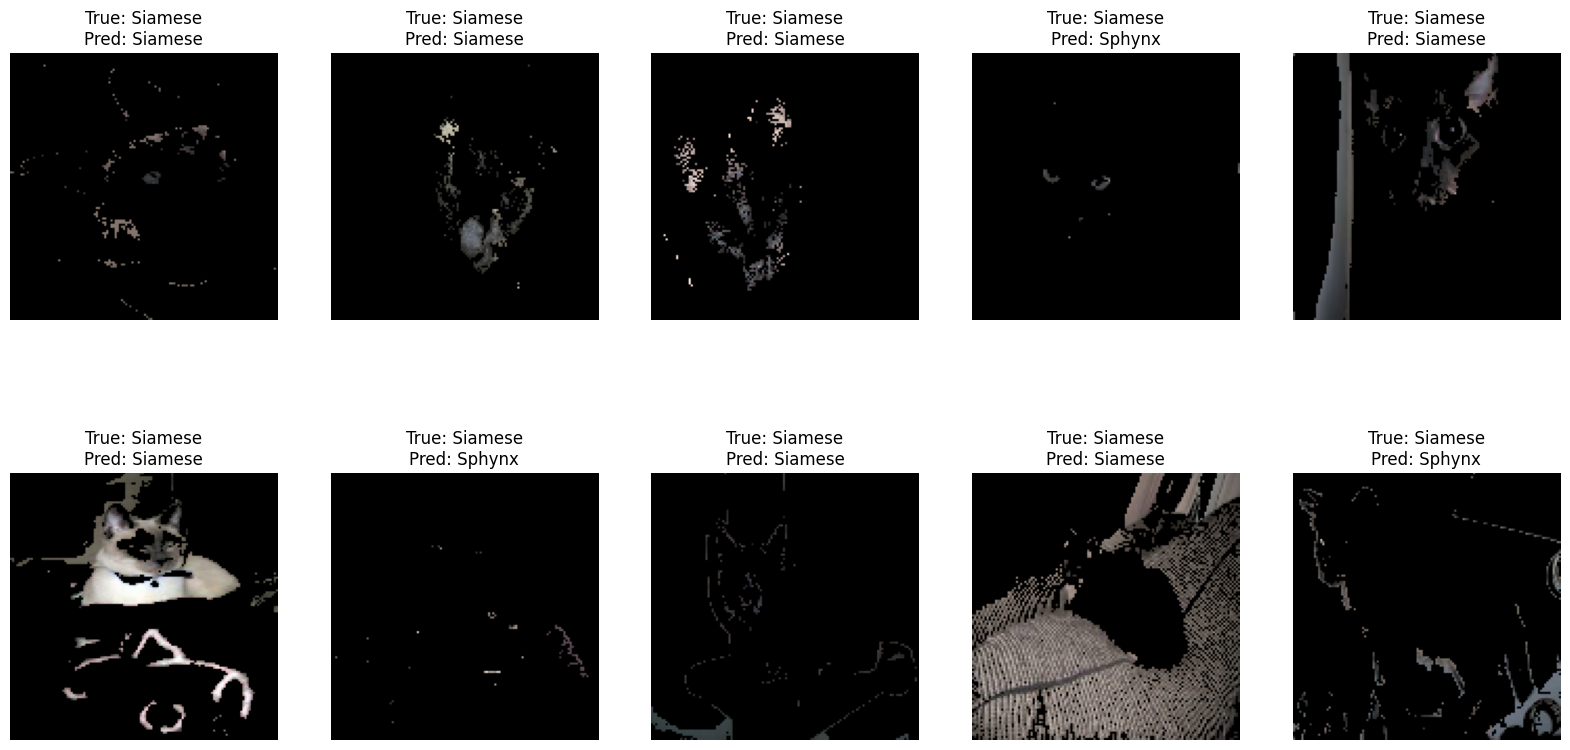

In [16]:
pipeline.predict_from_folder(test_folder="./images/test")

# Conclusiones según resultados

En este trabajo, se desarrolló un clasificador de imágenes capaz de distinguir entre dos razas específicas de gatos, Siamese y Sphynx, utilizando el conjunto de datos Oxford-IIIT Pet Dataset. El enfoque principal fue emplear las funcionalidades de OpenCV para preprocesar las imágenes, extraer características relevantes y, posteriormente, entrenar un modelo de aprendizaje automático con dichas características.

A lo largo del proyecto, se experimentaron diversas estrategias de preprocesamiento y extracción de características. La mejor combinación de funciones de preprocesamiento incluyó:

- **apply_mask**: Esta función se utilizó para eliminar el fondo de las imágenes y resaltar únicamente la figura del gato. Esto ayudó a reducir el ruido en las imágenes y centrarse en la región de interés.
- **highlight_gray_tones**: Esta función se aplicó para resaltar los tonos grisáceos en las imágenes, lo que es particularmente útil para distinguir los gatos de raza Sphynx, conocidos por su piel sin pelo y tonalidad grisácea.

Tras preprocesar las imágenes, se emplearon técnicas de aumento de datos para generar un conjunto de entrenamiento más robusto. La extracción de características se realizó utilizando el método ORB (Oriented FAST and Rotated BRIEF), que permitió capturar características distintivas de las imágenes.
Estos resultados indican una mejora significativa, aunque aun así una precisión muy baja, en la capacidad del modelo para distinguir entre las dos razas de gatos, especialmente en comparación con los intentos iniciales. La estrategia de preprocesamiento enfocada en eliminar el fondo y resaltar los tonos grisáceos demostró ser efectiva para mejorar la clasificación.

Finalmente, se entrenó y evaluó un modelo SVM (Support Vector Machine) con un kernel RBF (Radial Basis Function). Los resultados obtenidos mostraron una precisión y un accuracy de 0.637066 y 0.638368, respectivamente.

Estos resultados indican una mejora significativa, aunque aun así una precisión muy baja, en la capacidad del modelo para distinguir entre las dos razas de gatos, especialmente en comparación con los intentos iniciales. La estrategia de preprocesamiento enfocada en eliminar el fondo y resaltar los tonos grisáceos demostró ser efectiva para mejorar la clasificación.

Como se observa en la imagenes predichas hay ciertas imagenes que no se transforman según se desea o se tenía en mente . Y por ello el modelo falla en la predicción. Habría que investigra e iterar sobre estos resultados.

### Mejoras Futuras

Para continuar mejorando el rendimiento del modelo, se pueden considerar las siguientes acciones:

1. **Explorar otros modelos de aprendizaje automático**: Probar con modelos más complejos como Random Forest, Redes Neuronales Convolucionales (CNNs) y Ensembles.
2. **Implementar más técnicas de aumento de datos**: Generar un conjunto de datos aún más variado para robustecer el entrenamiento del modelo.
3. **Optimizar el preprocesamiento**: Investigar y aplicar otras técnicas de preprocesamiento y extracción de características que puedan capturar mejor las diferencias entre las razas de gatos.
4. Experimentar con otros métodos de extracción de características y transformaciones de imágenes para mejorar la capacidad del modelo para distinguir entre las dos razas de gatos.
